**Goal**: inspect an cluster code changes from some repos and see if there are any interesting patterns.

In [1]:
import project_path
from rdlib import *  # this imports the base libraries
import random
import numpy as np

In [2]:
DATA_PATH = "../data/code_changes"

FOLDER_DATASET_FILES = "../data/datasets/exp_v08/files_selected"
py_files = [
    f for f in os.listdir(FOLDER_DATASET_FILES) if f.endswith(".py")]

REPO_SAMPLE_SIZE = 10
SEED = 123

In [3]:
# get the first line of each file
first_lines = []
for f in py_files:
    with open(os.path.join(FOLDER_DATASET_FILES, f)) as file:
        first_lines.append(file.readline())

# from the first lines extract the repository name
# fist line = "# https://github.com/quantumyatra/QuantumMachineLearning/blob/e649c0469938000aae1d79c419c47a676c119361/notebooks/00_Course_Introduction.ipynb" -- > "quantumyatra/QuantumMachineLearning"
repos = []
for line in first_lines:
    if "github.com/" not in line:
        continue
    repo_chunks = line.split("github.com/")[1].split("/")[:2]
    repo = "/".join(repo_chunks)
    repos.append(repo)

# remove duplicates
repos = list(set(repos))
# sort alphabetically
repos.sort()
n_repos = len(repos)
print(f"Number of repositories: {n_repos}")


# pick a sample
if len(repos) > REPO_SAMPLE_SIZE:
    random.seed(SEED)
    random.shuffle(repos)
    selected_repos = repos[:REPO_SAMPLE_SIZE]
else:
    print("All repositories will be used")
    selected_repos = repos

print("Samples repositories:")
for i in range(REPO_SAMPLE_SIZE):
    print(f"{i+1}. {selected_repos[i]}")

Number of repositories: 2999
Samples repositories:
1. SRI-International/QC-PIRQ-Tutorials
2. stiandb/Thesis
3. Nicholas-py/Quantummmmmmmmmmmmm
4. burtr/Workbook
5. federico-rocco/VQE
6. Zer0112/quantum_job_shop
7. zapatacomputing/workshop-bell-state
8. andrea-ricciardi/qosf_project
9. decoyindus/qulib-DeutschJozsa
10. weiwenjiang/qc_mnist


In [4]:
def get_line_numbers(line: str) -> Tuple[int, int]:
    """Source: https://github.com/ishepard/pydriller/blob/a1c287cd782fe5a119f654bfb912d3e671a08a73/pydriller/domain/commit.py#L388
    """
    token = line.split(" ")
    numbers_old_file = token[1]
    numbers_new_file = token[2]
    delete_line_number = (
            int(numbers_old_file.split(",")[0].replace("-", "")) - 1
    )
    additions_line_number = int(numbers_new_file.split(",")[0]) - 1
    return delete_line_number, additions_line_number

def get_hunks_from_diff(diff:str) -> List[Dict[str, str]]:
    """Extract the code changes hunks from the diff.
    
    The code hunks are returned as a list of dictionaries. Each dictionary
    contains the following keys:
    - "before": the code before the change
    - "after": the code after the change
    """
    all_code_change_hunks = []
    lines = diff.split("\n")
    modified_lines = {
        "added": [],
        "deleted": [],
    }  # type: Dict[str, List[Tuple[int, str]]]

    count_deletions = 0
    count_additions = 0


    c_change_hunks = {
        "before": "",
        "after": "",
    }

    for line in lines:
        line = line.rstrip()
        count_deletions += 1
        count_additions += 1

        if line.startswith("@@"):
            count_deletions, count_additions = get_line_numbers(line)
            if c_change_hunks["before"] != "" or c_change_hunks["after"] != "":
                all_code_change_hunks.append(c_change_hunks)
            c_change_hunks = {
                "before": "",
                "after": "",
            }

        if line.startswith("-"):
            c_change_hunks["before"] = c_change_hunks["before"] + line[1:] + "\n"
            modified_lines["deleted"].append((count_deletions, line[1:]))
            count_additions -= 1

        if line.startswith("+"):
            c_change_hunks["after"] = c_change_hunks["after"] + line[1:] + "\n"
            modified_lines["added"].append((count_additions, line[1:]))
            count_deletions -= 1

        if line == r"\ No newline at end of file":
            count_deletions -= 1
            count_additions -= 1

    return all_code_change_hunks





In [5]:
from pydriller import Repository
from tqdm import tqdm

all_diffs = []

# iterate over all selected repos, and their commits to get all code changes
for repo in selected_repos:
    remote_url = f"https://github.com/{repo}.git"
    local_path = f"../data/repos/{repo}"
    parent_dir = os.path.dirname(local_path)
    os.makedirs(parent_dir, exist_ok=True)
    if not os.path.isdir(local_path):
        print(f"Cloning {repo} in {local_path}.")
        os.system(f"git clone {remote_url} {local_path}")
    repo_path = local_path


    pydriller_repo = Repository(repo_path, only_modifications_with_file_types=['.py'])
    for commit in tqdm(pydriller_repo.traverse_commits()):
        for modified_file in commit.modified_files:
            change_type = modified_file.change_type.name
            # change_type = 'ADD', 'DELETE', 'MODIFY', 'RENAME', 'UNKNOWN'
            # focus on MODIFY
            if not change_type == 'MODIFY':
                continue
            # focus on python files
            if not modified_file.new_path.endswith('.py'):
                continue
            code_hunks = get_hunks_from_diff(diff=modified_file.diff)
            record_for_code_hunks = [
                {
                    'repo': repo,
                    'commit': commit.hash,
                    'date': commit.author_date,
                    'filepath': modified_file.new_path,
                    'before': code_hunk['before'],
                    'after': code_hunk['after'],
                }
                for code_hunk in code_hunks
            ]
            all_diffs.extend(record_for_code_hunks)

# convert to dataframe
df_diffs = pd.DataFrame.from_records(all_diffs)
df_diffs.head()


Cloning SRI-International/QC-PIRQ-Tutorials in ../data/repos/SRI-International/QC-PIRQ-Tutorials.


Cloning into '../data/repos/SRI-International/QC-PIRQ-Tutorials'...
Checking out files: 100% (1156/1156), done.
3it [00:03,  1.04s/it]
Cloning into '../data/repos/stiandb/Thesis'...


Cloning stiandb/Thesis in ../data/repos/stiandb/Thesis.


34it [00:02, 12.40it/s]
Cloning into '../data/repos/Nicholas-py/Quantummmmmmmmmmmmm'...


Cloning Nicholas-py/Quantummmmmmmmmmmmm in ../data/repos/Nicholas-py/Quantummmmmmmmmmmmm.


8it [00:00, 20.59it/s]
Cloning into '../data/repos/burtr/Workbook'...


Cloning burtr/Workbook in ../data/repos/burtr/Workbook.


8it [00:04,  1.81it/s]
Cloning into '../data/repos/federico-rocco/VQE'...


Cloning federico-rocco/VQE in ../data/repos/federico-rocco/VQE.


17it [00:01, 16.36it/s]
Cloning into '../data/repos/Zer0112/quantum_job_shop'...


Cloning Zer0112/quantum_job_shop in ../data/repos/Zer0112/quantum_job_shop.


Checking out files: 100% (735/735), done.
2it [00:07,  3.67s/it]
Cloning into '../data/repos/zapatacomputing/workshop-bell-state'...


Cloning zapatacomputing/workshop-bell-state in ../data/repos/zapatacomputing/workshop-bell-state.


3it [00:00, 14.42it/s]
Cloning into '../data/repos/andrea-ricciardi/qosf_project'...


Cloning andrea-ricciardi/qosf_project in ../data/repos/andrea-ricciardi/qosf_project.


22it [00:01, 15.23it/s]
Cloning into '../data/repos/decoyindus/qulib-DeutschJozsa'...


Cloning decoyindus/qulib-DeutschJozsa in ../data/repos/decoyindus/qulib-DeutschJozsa.


2it [00:00,  8.91it/s]
Cloning into '../data/repos/weiwenjiang/qc_mnist'...


Cloning weiwenjiang/qc_mnist in ../data/repos/weiwenjiang/qc_mnist.


Checking out files: 100% (461/461), done.
124it [00:10, 11.32it/s]


,repo,commit,date,filepath,before,after
0,stiandb/Thesis,a101ce61a3808126f5e4652bae20621b57f9846d,2020-06-04 10:55:37+02:00,QATE/QATE.py,,"\t\t""""""\n\t\tInput:\n\t\t\tn_qubits (int) - Th..."
1,stiandb/Thesis,a101ce61a3808126f5e4652bae20621b57f9846d,2020-06-04 10:55:37+02:00,QATE/QATE.py,,"\t\t""""""\n\t\tInput:\n\t\t\tcircuit (qiskit Qua..."
2,stiandb/Thesis,a101ce61a3808126f5e4652bae20621b57f9846d,2020-06-04 10:55:37+02:00,QATE/QATE.py,,"\t\t""""""\n\t\tInput:\n\t\t\tclassical_bits (int..."
3,stiandb/Thesis,a101ce61a3808126f5e4652bae20621b57f9846d,2020-06-04 10:55:37+02:00,QATE/QATE.py,,"\t\t""""""\n\t\tOutput:\n\t\t\tE (float) - The en..."
4,stiandb/Thesis,a101ce61a3808126f5e4652bae20621b57f9846d,2020-06-04 10:55:37+02:00,QATE/main.py,factor = 2\n,factor = 0.13\n


In [6]:
# group by (repo, commit and filepath) and count how many 
df_grouped = df_diffs.groupby(['repo', 'commit', 'filepath']).size().reset_index(name='counts')
df_grouped.head()

,repo,commit,filepath,counts
0,Nicholas-py/Quantummmmmmmmmmmmm,38024fe78ec55b7be389cda7ff8393fa9cd6a855,groverquantum.py,1
1,Nicholas-py/Quantummmmmmmmmmmmm,e2b02739a4f1fcce7cce7285f5a2388df694dbb7,setup.py,1
2,andrea-ricciardi/qosf_project,18abfbcdffaaa6354d02c4ea16f911ec4ed9d55d,suzuki/grover.py,1
3,andrea-ricciardi/qosf_project,18abfbcdffaaa6354d02c4ea16f911ec4ed9d55d,suzuki/main.py,2
4,andrea-ricciardi/qosf_project,22461b87ab2fd972b8e70f9e3d71e86f9d60c846,suzuki/main_with_class.py,2


In [7]:
# iterate over all df_diffs and split the diff in multiple rows based on the split
for i, row in df_diffs.iterrows():
    url = f"https://github.com/{row['repo']}/commit/{row['commit']}/{row['filepath']}"
    print(url)
    print("Processing deleted_block", i)
    break



https://github.com/stiandb/Thesis/commit/a101ce61a3808126f5e4652bae20621b57f9846d/QATE/QATE.py
Processing deleted_block 0


## Create embeddings with LLM

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch

# MODEL_NAME = "microsoft/codebert-base"

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModel.from_pretrained(MODEL_NAME)

from unixcoder import UniXcoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unicoder = UniXcoder("microsoft/unixcoder-base")
model_unicoder.to(device)

UniXcoder(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51416, 768, padding_idx=1)
      (position_embeddings): Embedding(1026, 768, padding_idx=1)
      (token_type_embeddings): Embedding(10, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

In [9]:
MODEL_NAME = "bigcode/tiny_starcoder_py"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_hf = AutoModel.from_pretrained(MODEL_NAME)
model_hf.to(device)

GPTBigCodeModel(
  (wte): Embedding(49152, 768)
  (wpe): Embedding(8192, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPTBigCodeBlock(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPTBigCodeAttention(
        (c_attn): Linear(in_features=768, out_features=896, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPTBigCodeMLP(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        (act): PytorchGELUTanh()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPTBigCodeBlock(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPTBigCodeAttention(
        (c_a

In [10]:

def get_embeddings(model, text, tokenizer=None):
    if str(model).startswith("UniXcoder"):
        tokens_ids = model.tokenize([text], max_length=512, mode="<encoder-only>")
        source_ids = torch.tensor(tokens_ids).to(device)
        tokens_embeddings, text_embeddings = model(source_ids)
        return text_embeddings.squeeze().detach().cpu().tolist()
    else:
        # huggingface GPT like model
        tokens_ids = tokenizer.encode(text)
        tokens_ids = torch.tensor(tokens_ids).to(device)
        if len(tokens_ids) == 0:
            print("Warning: tokens_ids == 0")
            tokens_embeddings = [0] * 768
            return tokens_embeddings
        tokens_embeddings = model(tokens_ids)[0][0]
        tokens_embeddings = tokens_embeddings.squeeze().detach().cpu().tolist()
        return tokens_embeddings



embeddings = get_embeddings(
    # model=model_unicoder,
    model=model_hf,
    text="def foo(): return 1",
    tokenizer=tokenizer)

print(len(embeddings))

768


In [11]:
# compute the embedding of before and after creating two columns
df_diffs["before_embedding"] = df_diffs["before"].apply(lambda x: get_embeddings(model_hf, x, tokenizer))
df_diffs["after_embedding"] = df_diffs["after"].apply(lambda x: get_embeddings(model_hf, x, tokenizer))

# covert them to numpy arrays and do pairwise subtraction
df_diffs["diff_embedding"] = df_diffs.apply(
    lambda x: list(np.array(x["after_embedding"]) - np.array(x["before_embedding"])), axis=1
)

# concatenate before and after embeddings
df_diffs["concat_embedding"] = df_diffs.apply(
    lambda x: list(np.concatenate((np.array(x["before_embedding"]), np.array(x["after_embedding"])))), axis=1
)
df_diffs.head()


RuntimeError: CUDA out of memory. Tried to allocate 2.10 GiB (GPU 0; 14.76 GiB total capacity; 10.56 GiB already allocated; 1.33 GiB free; 12.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [109]:
# compute hierarchical clustering of code changes
# and visualize the results
from sklearn.cluster import AgglomerativeClustering

EMBEDDING_COLUMN_NAME = "concat_embedding"
N_CLUSTERS = 4
MAX_LINES_OF_CODE = 5

df_to_cluster = df_diffs.copy()
# keep only those with both before and after not empty and with less than 20 
# lines of code changed
df_to_cluster = df_to_cluster[df_to_cluster["before"] != ""]
df_to_cluster = df_to_cluster[df_to_cluster["after"] != ""]
df_to_cluster = df_to_cluster[
    (df_to_cluster["before"].str.count("\n") <= MAX_LINES_OF_CODE) &
    (df_to_cluster["after"].str.count("\n") <= MAX_LINES_OF_CODE)
]

df_embeddings = df_to_cluster[EMBEDDING_COLUMN_NAME].apply(pd.Series)
print(f"Shape of embeddings: {df_embeddings.shape}")


# compute hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=5).fit(df_embeddings)

Shape of embeddings: (253, 1536)


Shape of embeddings (reduced): (253, 3)


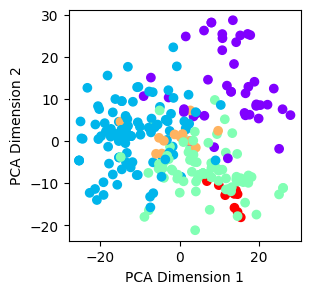

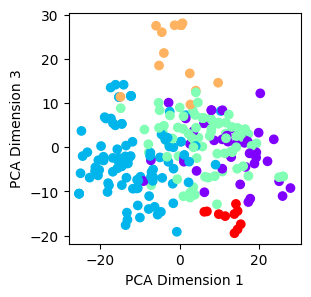

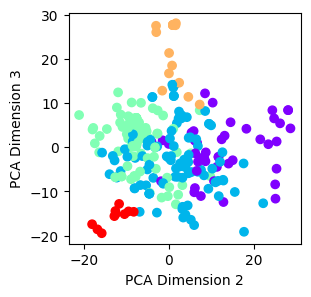

In [110]:
from sklearn.decomposition import PCA

N_PCA = 3

# visualize the results
from itertools import combinations

pca = PCA(n_components=N_PCA)
df_embeddings_reduced = pca.fit_transform(df_embeddings)
print(f"Shape of embeddings (reduced): {df_embeddings_reduced.shape}")

# check all combinations of two dimensions
for x, y in combinations(range(N_PCA), 2):
    plt.figure(figsize=(3, 3))
    plt.scatter(df_embeddings_reduced[:, x], df_embeddings_reduced[:, y], c=clustering.labels_, cmap='rainbow')
    plt.xlabel(f"PCA Dimension {x+1}")
    plt.ylabel(f"PCA Dimension {y+1}")
    plt.show()

In [111]:
df_diffs_w_labels = df_to_cluster.copy()
df_diffs_w_labels['label'] = clustering.labels_

In [113]:
# print some example of each label, show the "before" column, and the "after" column
unique_labels = df_diffs_w_labels['label'].unique()
for label in unique_labels:
    print("&" * 20)
    df_cluster = df_diffs_w_labels[
        df_diffs_w_labels['label'] == label]
    df_selection = df_cluster.sample(n=5, random_state=12)
    print("Cluster: ", label, " - Size: ", len(df_cluster))
    for index, row in df_selection.iterrows():
        print(row['before'])
        print("----")
        print(row['after'])
        print('====================')

&&&&&&&&&&&&&&&&&&&&
Cluster:  1  - Size:  101
# Written by Matthieu Sarkis (https://github.com/MatthieuSarkis)

----
# Written by Matthieu Sarkis (https://github.com/MatthieuSarkis).

from qbench.postselection_all_cases import benchmark_using_postselection_all_cases

----
from qbench.postselection import benchmark_using_postselection

def check_GS(state, simulator, N_reg = 3):

----
def check_GS(coo_state, simulator, N_reg = 3, plaq = False):
    state = coo_state.toarray()[0]

# Written by Matthieu Sarkis, https://github.com/MatthieuSarkis

----
# Written by Matthieu Sarkis (https://github.com/MatthieuSarkis).

from qbench.direct_sum import benchmark_using_controlled_unitary

----
from qbench.schemes.direct_sum import benchmark_using_controlled_unitary

&&&&&&&&&&&&&&&&&&&&
Cluster:  0  - Size:  43
        r"""Unitary $U^\dagger$ defining alternative measurement.
                 ┌───┐┌─────────────┐┌───┐
              q: ┤ H ├┤ Phase(-phi) ├┤ H ├
                 └───┘└─────────────